**Machine Learning Project: Players Potential Prediction**

Business Problem

The goal is to predict the class (average, highlighted) of football players based on the scores given to their attributes by scouts.

Scout: An expert who observes promising athletes, determining their current skills and potential.

In [1]:

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Step 1: Data Loading
attributes_df = pd.read_csv("scoutium_attributes.csv",sep=';')
labels_df = pd.read_csv("scoutium_potential_labels.csv",sep=';')

In [9]:
attributes_df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.0
1,4915,62935,177676,1361061,2,12818495,4323,56.0
2,4915,62935,177676,1361061,2,12818495,4324,67.0
3,4915,62935,177676,1361061,2,12818495,4325,56.0
4,4915,62935,177676,1361061,2,12818495,4326,45.0


In [10]:
labels_df.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [ ]:
#Step 2: Data Merging
df = pd.merge(attributes_df, labels_df,
              on=['task_response_id', 'match_id', 'evaluator_id', 'player_id'],
              how='inner')
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.0,average
1,4915,62935,177676,1361061,2,12818495,4323,56.0,average
2,4915,62935,177676,1361061,2,12818495,4324,67.0,average
3,4915,62935,177676,1361061,2,12818495,4325,56.0,average
4,4915,62935,177676,1361061,2,12818495,4326,45.0,average


In [12]:
df.shape

(10730, 9)

In [ ]:
#Step 3: Remove rows with position_id = 1 (Goalkeeper)
df = df[df["position_id"] != 1]

df.shape

(10030, 9)

In [ ]:
#Step 4: Filtering "Below Average"
#Remove the below_average class from the potential_label column. (The below_average class constitutes approximately 1% of the entire dataset).
df = df[df["potential_label"] != 'below_average']
df["potential_label"].value_counts(normalize=True)

potential_label
average        0.800687
highlighted    0.199313
Name: proportion, dtype: float64

In [ ]:
#Step 5: Pivot Table Creation
pivot_df = df.pivot_table(index=['player_id', 'position_id', 'potential_label'],
                          columns='attribute_id',
                          values='attribute_value')
pivot_df.head()
print("\nPivot Table Şekli:", pivot_df.shape)


Pivot Table (İlk 5 satır):
attribute_id                           4322  4323  4324  4325  4326  4327  \
player_id position_id potential_label                                       
1355710   7           average          50.5  50.5  34.0  50.5  45.0  45.0   
1356362   9           average          67.0  67.0  67.0  67.0  67.0  67.0   
1356375   3           average          67.0  67.0  67.0  67.0  67.0  67.0   
          4           average          67.0  78.0  67.0  67.0  67.0  78.0   
1356411   9           average          67.0  67.0  78.0  78.0  67.0  67.0   

attribute_id                           4328  4329  4330  4332  ...  4352  \
player_id position_id potential_label                          ...         
1355710   7           average          45.0  45.0  50.5  56.0  ...  56.0   
1356362   9           average          67.0  67.0  67.0  67.0  ...  67.0   
1356375   3           average          67.0  78.0  67.0  67.0  ...  67.0   
          4           average          78.0  78.0  5

In [ ]:
#Step 6: Label Encoding
#Numerically encode the potential_label categories (average, highlighted) using the LabelEncoder function.

pivot_df = pivot_df.reset_index()

# Label Encoding
le = LabelEncoder()
pivot_df['potential_label'] = le.fit_transform(pivot_df['potential_label'])

pivot_df['potential_label'].value_counts()

# Let's check which tag corresponds to which number:
# 0 -> 'average', 1 -> 'highlighted' 
dict(zip(le.classes_, le.transform(le.classes_)))
# Bu, 'average' (0) ve 'highlighted' (1) anlamına gelir.

{'average': np.int64(0), 'highlighted': np.int64(1)}

In [ ]:
#Step 7: Numerical Columns List
#Assign the numerical feature columns (the attributes) to a list named num_cols.
num_cols = [col for col in pivot_df.columns if col not in ['player_id', 'position_id', 'potential_label']]
num_cols

[4322,
 4323,
 4324,
 4325,
 4326,
 4327,
 4328,
 4329,
 4330,
 4332,
 4333,
 4335,
 4338,
 4339,
 4340,
 4341,
 4342,
 4343,
 4344,
 4345,
 4348,
 4349,
 4350,
 4351,
 4352,
 4353,
 4354,
 4355,
 4356,
 4357,
 4407,
 4408,
 4423,
 4426]

In [ ]:
#Step 8: Data Scaling
scaler = StandardScaler()
pivot_df[num_cols] = scaler.fit_transform(pivot_df[num_cols])
pivot_df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.542606,-0.559398,-1.404764,-0.437916,-0.766602,-0.794802,-0.907351,...,0.012848,-1.281899,-1.132245,-0.494569,-1.234869,-1.519578,-0.142650,-1.487256,-0.955381,-0.252741
1,1356362,9,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,...,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
2,1356375,3,0,0.595327,0.560776,0.678677,0.682837,0.722639,0.722929,0.601190,...,0.786581,0.813645,1.052769,0.631718,0.914913,0.768231,0.529664,0.668713,0.403717,1.041611
3,1356375,4,0,0.595327,1.307560,0.678677,0.682837,0.722639,1.481795,1.355461,...,1.560314,0.813645,0.428479,0.631718,0.198319,0.768231,-0.142650,0.668713,-0.275832,-0.252741
4,1356411,9,0,0.595327,0.560776,1.373158,1.430006,0.722639,0.722929,0.601190,...,0.786581,0.115130,0.428479,0.631718,0.198319,0.768231,1.874292,-0.049944,1.083267,1.041611


In [ ]:
#Step 9: Model Development and Evaluation
#Develop a Machine Learning model that predicts the potential labels of the football players with minimum error.
X = pivot_df[num_cols]  # Ölçeklendirilmiş nitelikler
y = pivot_df['potential_label'] # Hedef değişken

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Model: Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Model Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("\n--- Machine Learning Model (Random Forest) Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")




--- Machine Learning Model (Random Forest) Metrics ---
Accuracy: 0.8780
Precision: 0.8889
Recall: 0.4706
F1-Score: 0.6154
ROC AUC Score: 0.8833


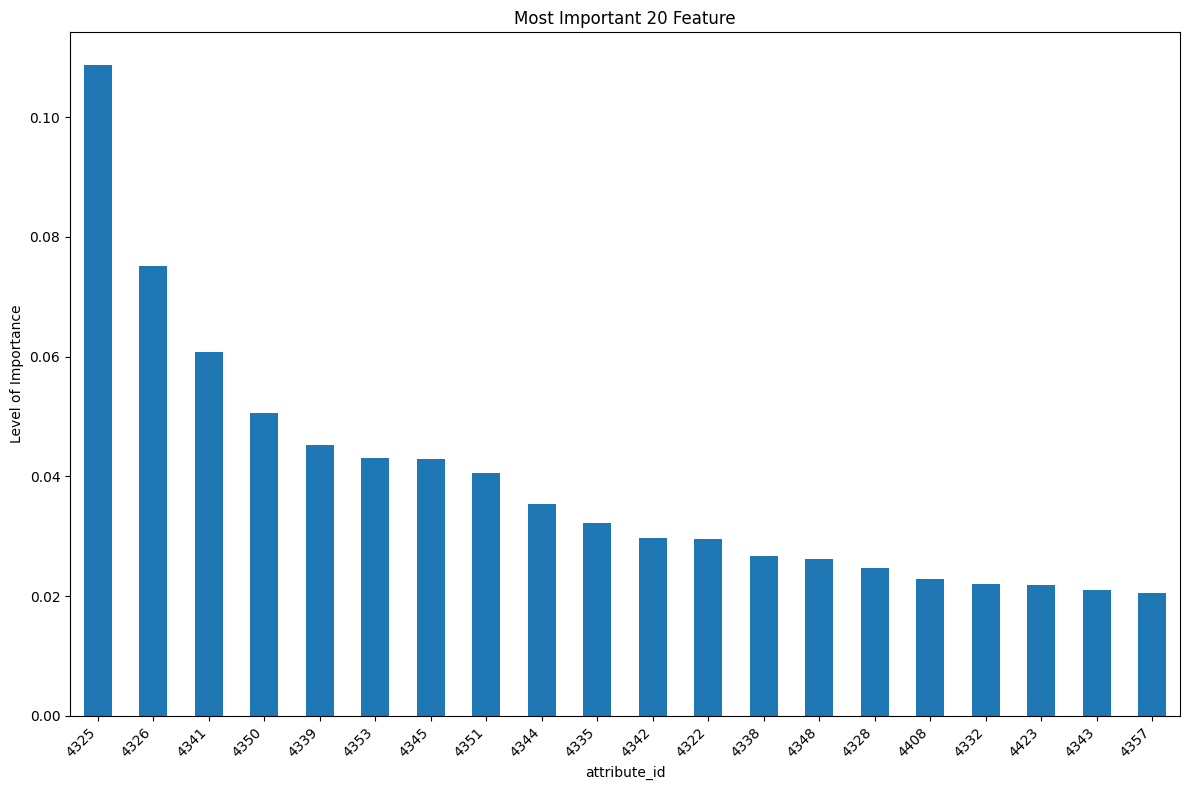


--- Most Important 10 Feature and Level of Importance ---
attribute_id
4325    0.108749
4326    0.075211
4341    0.060806
4350    0.050668
4339    0.045208
4353    0.043085
4345    0.042918
4351    0.040594
4344    0.035390
4335    0.032173
dtype: float64


In [ ]:
#Step 10: Plot the ranking of the features using the feature_importance function, which indicates the importance level of the variables.
# Extracting Variable Importances
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# Ranking and visualizing the top 20 features
top_features = feature_importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
top_features.plot(kind='bar')
plt.title("Most Important 20 Feature")
plt.ylabel("Level of Importance")
plt.xlabel("attribute_id")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n--- Most Important 10 Feature and Level of Importance ---")
print(feature_importances.sort_values(ascending=False).head(10))